# Perturbing cell type composition

In [1]:
import importlib
import logging

import dask.dataframe as dd
import helpers
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from upath import UPath

In [2]:
helpers.logging.configure_logging()
logging.getLogger("helpers").setLevel("DEBUG")
logger = logging.getLogger(__name__)
logger.setLevel("DEBUG")
logger.debug("test")

2023-01-20 12:32:26,329 20590/MainThread __main__ DEBUG
test


In [5]:
!gsutil ls gs://liulab/differential_composition/20230120_04h22m54s

gs://liulab/differential_composition/20230120_04h22m54s/run_id=00/
gs://liulab/differential_composition/20230120_04h22m54s/run_id=01/
gs://liulab/differential_composition/20230120_04h22m54s/run_id=02/
gs://liulab/differential_composition/20230120_04h22m54s/run_id=03/
gs://liulab/differential_composition/20230120_04h22m54s/run_id=04/
gs://liulab/differential_composition/20230120_04h22m54s/run_id=05/
gs://liulab/differential_composition/20230120_04h22m54s/run_id=06/
gs://liulab/differential_composition/20230120_04h22m54s/run_id=07/
gs://liulab/differential_composition/20230120_04h22m54s/run_id=08/
gs://liulab/differential_composition/20230120_04h22m54s/run_id=09/


In [17]:
path_root = UPath("gs://liulab/differential_composition") / "20230120_04h22m54s"
# 20221208_14h18m38s last week
# 20221215_05h09m48s like last week but with more 0 perturbation experiments
# 20221215_05h06m59s recreation of last week, showed a significantly different perturbation=0
# 20221215_04h42m35s with N = 1000
# 20221215_06h29m44s a few experiments per perturbation
# 20230120_04h22m54s better fraction perturbation and sampling

In [21]:
!gsutil ls {path_root}

gs://liulab/differential_composition/20230120_04h22m54s/run_id=00/
gs://liulab/differential_composition/20230120_04h22m54s/run_id=01/
gs://liulab/differential_composition/20230120_04h22m54s/run_id=02/
gs://liulab/differential_composition/20230120_04h22m54s/run_id=03/
gs://liulab/differential_composition/20230120_04h22m54s/run_id=04/
gs://liulab/differential_composition/20230120_04h22m54s/run_id=05/
gs://liulab/differential_composition/20230120_04h22m54s/run_id=06/
gs://liulab/differential_composition/20230120_04h22m54s/run_id=07/
gs://liulab/differential_composition/20230120_04h22m54s/run_id=08/
gs://liulab/differential_composition/20230120_04h22m54s/run_id=09/


## load data

In [87]:
df_fractions = dd.read_parquet(path_root / "**" / "fractions.parquet").compute()
df_fractions[["group_id", "sample_id"]] = (
    df_fractions.index.get_level_values("sample_id").str.split("/", expand=True).tolist()
)
process_row = lambda row: row["malignant_means"].split(",")[0 if row["group_id"] == "low" else 1]
df_fractions["malignant_mean_value"] = df_fractions.apply(process_row, axis=1)
df_fractions = df_fractions.set_index(["malignant_means", "group_id", "malignant_mean_value", "sample_id", "run_id"])

In [88]:
df_fractions

cell_type                                                               B  \
malignant_means group_id malignant_mean_value sample_id  run_id             
0.6,0.8         high     0.8                  sample_000 0       0.054108   
                                              sample_001 0       0.000000   
                                              sample_002 0       0.000000   
                                              sample_003 0       0.026253   
                                              sample_004 0       0.000841   
...                                                                   ...   
0.71,0.71       low      0.71                 sample_045 9       0.000000   
                                              sample_046 9       0.033231   
                                              sample_047 9       0.000000   
                                              sample_048 9       0.000000   
                                              sample_049 9       0.000000   

cell_type                                                             CAF  \
malignant_means group_id malignant_mean_value sample_id  run_id             
0.6,0.8         high     0.8                  sample_000 0       0.131469   
                                              sample_001 0       0.104245   
                                              sample_002 0       0.082603   
                                              sample_003 0       0.024251   
                                              sample_004 0       0.036137   
...                                                                   ...   
0.71,0.71       low      0.71                 sample_045 9       0.097722   
                                              sample_046 9       0.092778   
                                              sample_047 9       0.377149   
                                              sample_048 9       0.172522   
                                              sample_049 9       0.543917   

cell_type                                                        Endothelial  \
malignant_means group_id malignant_mean_value sample_id  run_id                
0.6,0.8         high     0.8                  sample_000 0          0.058064   
                                              sample_001 0          0.011654   
                                              sample_002 0          0.005060   
                                              sample_003 0          0.007921   
                                              sample_004 0          0.000000   
...                                                                      ...   
0.71,0.71       low      0.71                 sample_045 9          0.000000   
                                              sample_046 9          0.031706   
                                              sample_047 9          0.163082   
                                              sample_048 9          0.019287   
                                              sample_049 9          0.044656   

cell_type                                                        Macrophage  \
malignant_means group_id malignant_mean_value sample_id  run_id               
0.6,0.8         high     0.8                  sample_000 0         0.070189   
                                              sample_001 0         0.038061   
                                              sample_002 0         0.142786   
                                              sample_003 0         0.076499   
                                              sample_004 0         0.000000   
...                                                                     ...   
0.71,0.71       low      0.71                 sample_045 9         0.332794   
                                              sample_046 9         0.082242   
                                              sample_047 9         0.165351   
                                              sample_048 9         0.062990   
       

In [6]:
df_bulk_rnaseq = None

## data checks

### dist plot of fractions per experiment

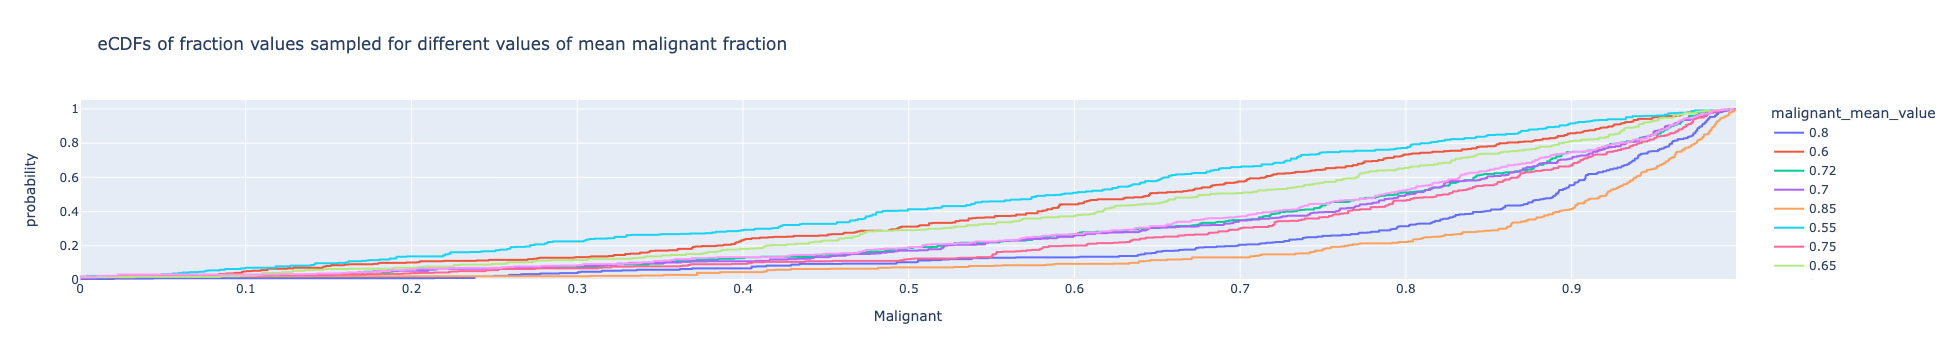

In [89]:
df = df_fractions.reset_index()
# df["color"] = df.apply(lambda row: "{} - {}".format(row["malignant_means"], row["group_id"]), axis=1)
fig = px.ecdf(
    df,
    x="Malignant",
    color="malignant_mean_value",
    title="eCDFs of fraction values sampled for different values of mean malignant fraction",
)
# fig.show(renderer="png", width=1000)
fig.show()

In [137]:
import plotly.io as pio

pio.templates.default = "plotly"

plotly_config = {
    "toImageButtonOptions": {
        "format": "png",  # one of png, svg, jpeg, webp
        "height": 500,
        "width": 900,
        "scale": 2,  # Multiply title/legend/axis/canvas sizes by this factor
    }
}

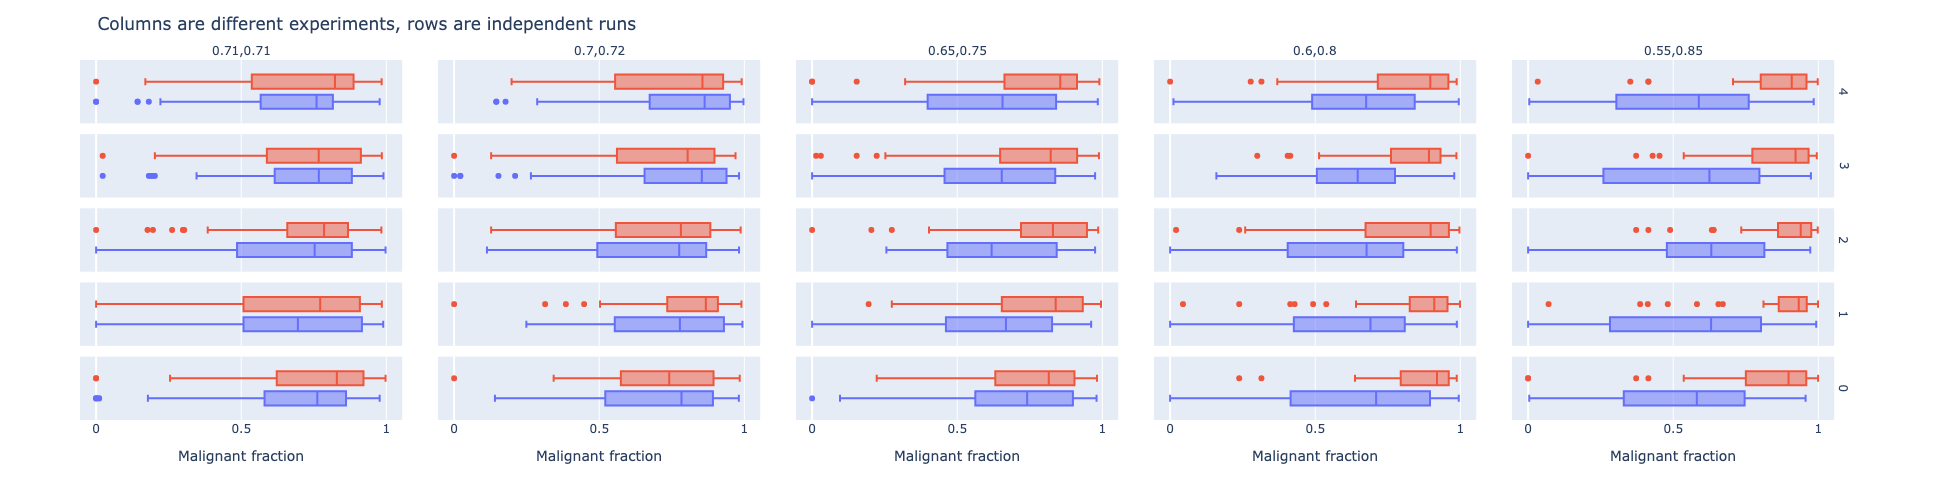

In [139]:
df = df_fractions.reset_index()
df = df.astype({"run_id": int})
df = df.query("run_id < 5")
df.sort_values(["malignant_means"], ascending=False, inplace=True)
fig = px.box(
    df,
    x="Malignant",
    facet_col="malignant_means",
    facet_row="run_id",
    color="group_id",
    labels={"Malignant": "Malignant fraction"},
)
fig.for_each_annotation(
    lambda a: a.update(text=a.text.split("=")[-1])
)  # https://github.com/plotly/plotly_express/issues/36#issuecomment-589718357
fig.update_layout(showlegend=False)
fig.update_layout(width=1000, height=500, title="Columns are different experiments, rows are independent runs")
fig.show(config=plotly_config)

### what are fraction means for each group and experiment?

In [ ]:
fig = px.box(
    df.reset_index(),
    x="Malignant",
    facet_col="perturbation",
    facet_row="simulation",
    color="treatment",
    labels={"Malignant": "Malignant fraction"},
)
fig.update_layout(width=1500, height=600, title="Columns are different perturbations, rows are independent runs",)

## volcano plots from run_id=00

- for bulk RNA-seq
- for inferred malignant-specific RNA-seq

In [ ]:
importlib.reload(helpers.deg_analysis)

from helpers.deg_analysis import add_fdr_lines, make_volcano_facets

fig = make_volcano_facets(all_dge_results, horizontal=True)
fig = add_fdr_lines(fig, all_dge_results, horizontal=True)
# fig.update_layout(title=title, height=1200)
fig.update_layout(height=700, width=1000)


## plot of false positives

## plot of p-values